## Testing out the `bracket_builder` package I was working on last year

In [1]:
import os
import sys
import pandas as pd
import bracket_builder.draw as bb
import bracket_builder.calculate as brac_calc

### Test out drawing standard 64 team bracket

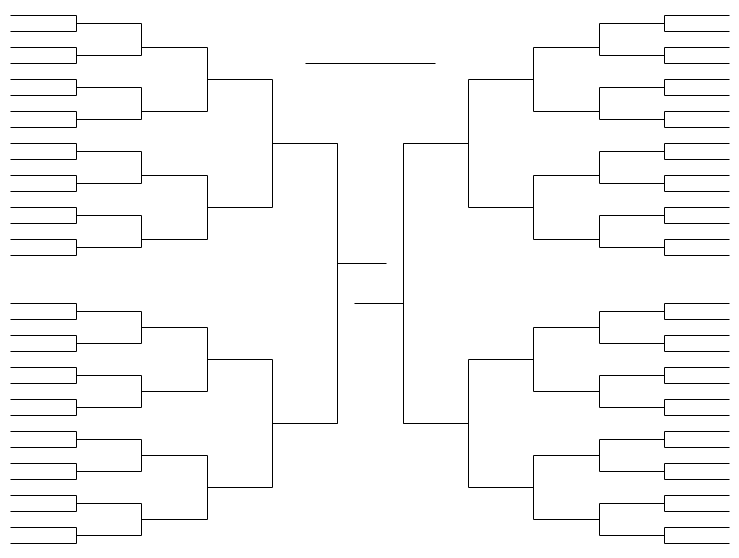

In [2]:
b = bb.Bracket(64)
b.draw_bracket()

### Adding names

In [3]:
os.chdir("../data/women/")

In [4]:
## Get past tournament data to test with
seeds = pd.read_csv("WNCAATourneySeeds.csv")
teams = pd.read_csv("WTeams.csv")
seeds = seeds.merge(teams[['TeamID', 'TeamName']])
ncaa_slots = pd.read_csv("WNCAATourneySlots.csv")

In [5]:
def remove_one_playin(ncaa_data):
    
    ### Remove the play-in seed with the seed starting with "b" for now
    #### Would ideally choose the one with the greater win prob. but doesn't matter much
    ncaa_data['seed_endswith_b'] = ncaa_data['Seed'].apply(lambda x: True if x.endswith('b') else False)
    ncaa_data = ncaa_data[~ncaa_data['seed_endswith_b']].copy()
    
    ## Change the Seed for the one starting with a
    ncaa_data['Seed'] = ncaa_data['Seed'].apply(lambda x: x[:-1] if x.endswith('a') else x)
    
    ## Drop the seed_endswith_b column
    ncaa_data = ncaa_data.drop(columns = ['seed_endswith_b'])
    
    return ncaa_data

In [11]:
### Limit to current season
seeds_2021 = seeds[seeds['Season'] == 2021].copy()

## Remove the 'b' play-in seeds and remove 'a' suffix from the deemed 'winner'
seeds_2021 = remove_one_playin(seeds_2021)

## Split the seed into Region and number parts
seeds_2021['seed_num']      = seeds_2021['Seed'].apply(lambda x: int(x[1:]))
seeds_2021['seed_region']   = seeds_2021['Seed'].apply(lambda x: x[0])
seeds_2021['seed_region_2'] = seeds_2021['seed_region'].apply(lambda x: 'Z' if x == 'Y'
                                                               else 'Y' if x == 'Z'
                                                               else x)

## Proper ordering for seeds within each region in the 1st round
seed_order = pd.DataFrame({'seed_num': [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15],
                           'seed_ord': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]})
seeds_2021 = seeds_2021.merge(seed_order)

## Sort it properly and check it out
seeds_2021 = seeds_2021.sort_values(['seed_region_2', 'seed_ord'])
seeds_2021.head(16)

,Season,Seed,TeamID,TeamName,seed_num,seed_region,seed_region_2,seed_ord
2,2021,W01,3390,Stanford,1,W,W,1
62,2021,W16,3430,Utah Valley,16,W,W,2
54,2021,W08,3329,Oklahoma St,8,W,W,3
46,2021,W09,3448,Wake Forest,9,W,W,4
12,2021,W05,3283,Missouri St,5,W,W,5
26,2021,W12,3413,UC Davis,12,W,W,6
28,2021,W04,3116,Arkansas,4,W,W,7
51,2021,W13,3460,Wright St,13,W,W,8
18,2021,W06,3332,Oregon,6,W,W,9
42,2021,W11,3377,South Dakota,11,W,W,10


In [7]:
## Get submission for round 2
subs_path = "subs/submission_probs_2021-03-18.csv"
sub = pd.read_csv(subs_path)
sub['Season'] = sub['ID'].apply(lambda x: x.split('_')[0]).astype(int)
sub['TeamID_1']  = sub['ID'].apply(lambda x: x.split('_')[1]).astype(int)
sub['TeamID_2']  = sub['ID'].apply(lambda x: x.split('_')[2]).astype(int)

## Merge team 1 name
teams = teams.rename(columns={'TeamName': 'TeamName_1',
                              'TeamID': 'TeamID_1'})
teams = teams[['TeamName_1', 'TeamID_1']]
sub = sub.merge(teams, on='TeamID_1', how='left')

## Merge team 2 name
teams = teams.rename(columns={'TeamName_1': 'TeamName_2',
                              'TeamID_1': 'TeamID_2'})
sub = sub.merge(teams, on='TeamID_2', how='left')

sub.head()

,ID,Pred,Season,TeamID_1,TeamID_2,TeamName_1,TeamName_2
0,2021_3104_3112,0.228951,2021,3104,3112,Alabama,Arizona
1,2021_3104_3116,0.311540,2021,3104,3116,Alabama,Arkansas
2,2021_3112_3116,0.603798,2021,3112,3116,Arizona,Arkansas
3,2021_3104_3124,0.081652,2021,3104,3124,Alabama,Baylor
4,2021_3112_3124,0.230434,2021,3112,3124,Arizona,Baylor


In [8]:
round_by_round_probs_df = brac_calc.compute_conditional_probs(subs_path, league = 'women')

round_by_round_probs_df.sort_values('Champ', ascending = False).head(20)

,TeamName,TeamID,Round1,Round2,Sweet16,Elite8,Final4,Final,Champ
8,Connecticut,3163,1,0.988139,0.949552,0.871386,0.615632,0.494510,0.336871
46,Stanford,3390,1,0.990361,0.932854,0.810587,0.605986,0.425608,0.232946
4,Baylor,3124,1,0.974815,0.890434,0.730253,0.311089,0.217689,0.120613
43,South Carolina,3376,1,0.971175,0.895183,0.722524,0.409085,0.177876,0.068848
27,Maryland,3268,1,0.961021,0.864056,0.615518,0.368715,0.164699,0.065634
23,Louisville,3257,1,0.946190,0.832652,0.598211,0.240361,0.127464,0.047974
34,NC State,3301,1,0.950545,0.815526,0.535806,0.335513,0.109190,0.047222
51,Texas A&M,3401,1,0.949209,0.817465,0.509874,0.263597,0.072600,0.027145
55,UCLA,3417,1,0.943962,0.742109,0.302497,0.136793,0.042184,0.011288
17,Indiana,3231,1,0.936510,0.536745,0.234029,0.114795,0.025512,0.007861


In [9]:
round_by_round_probs_df.to_csv("viz-files/round-by-round-probs-2021-03-18.csv", index = False)

### Plot what it predicts!


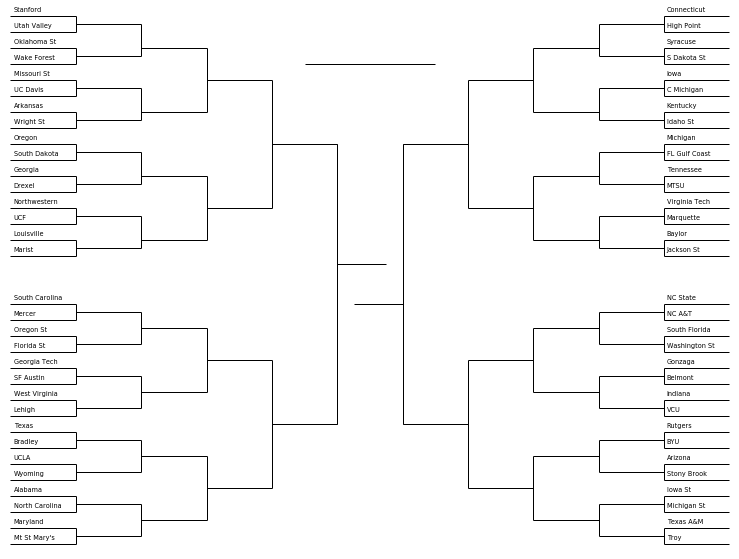

In [12]:
### Label team names (note: had to switch 'Z' and 'Y' region labels.)
b_2 = bb.Bracket(n_teams = 64, team_names = list(seeds_2021['TeamName']))
b_2.draw_bracket()
b_2.label_teams()

## To-Do

  1. Fix up the `label_winners()` function and/or get a pipeline to easily get winners in required order
  2. Complete the `draw_weighted_lines()` function to draw lines in the team's colors.
  3. Get a pipeline in `calculate` going to `compute_conditional_probs()` in a way that works seamlessly with weighted lines.